**RNN TEXT CLASSIFICATION**

 Setup and Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


import random
import os
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("✓ Core libraries imported")

✓ Core libraries imported


In [13]:
import matplotlib.pyplot as plt
def plot_training_history(history, title):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()



In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string


nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("✓ NLP libraries imported")

✓ NLP libraries imported


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

print("✓ Scikit-learn imported")

✓ Scikit-learn imported


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, SimpleRNN, Embedding, Dropout,
    Bidirectional, GlobalMaxPooling1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(SEED)


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ TensorFlow imported - {len(gpus)} GPU(s) available")
    except RuntimeError as e:
        print(e)
else:
    print("✓ TensorFlow imported - Running on CPU")

✓ TensorFlow imported - Running on CPU


In [6]:
!pip install gensim
from gensim.models import Word2Vec
import gensim.downloader as api

print("✓ Gensim (Word2Vec) imported")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 66.5 MB/s eta 0:00:00
✓ Gensim (Word2Vec) imported


Load and Explore Dataset

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Dataset loaded successfully!")
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nColumns: {list(train_df.columns)}")

Dataset loaded successfully!
Training samples: 120,000
Test samples: 7,600

Columns: ['Class Index', 'Title', 'Description']


In [8]:
print("Sample data:")
train_df.head()

Sample data:


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [9]:
print("Dataset Info:")
print(train_df.info())
print("\nMissing values:")
print(train_df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB
None

Missing values:
Class Index    0
Title          0
Description    0
dtype: int64


 Class Distribution Analysis

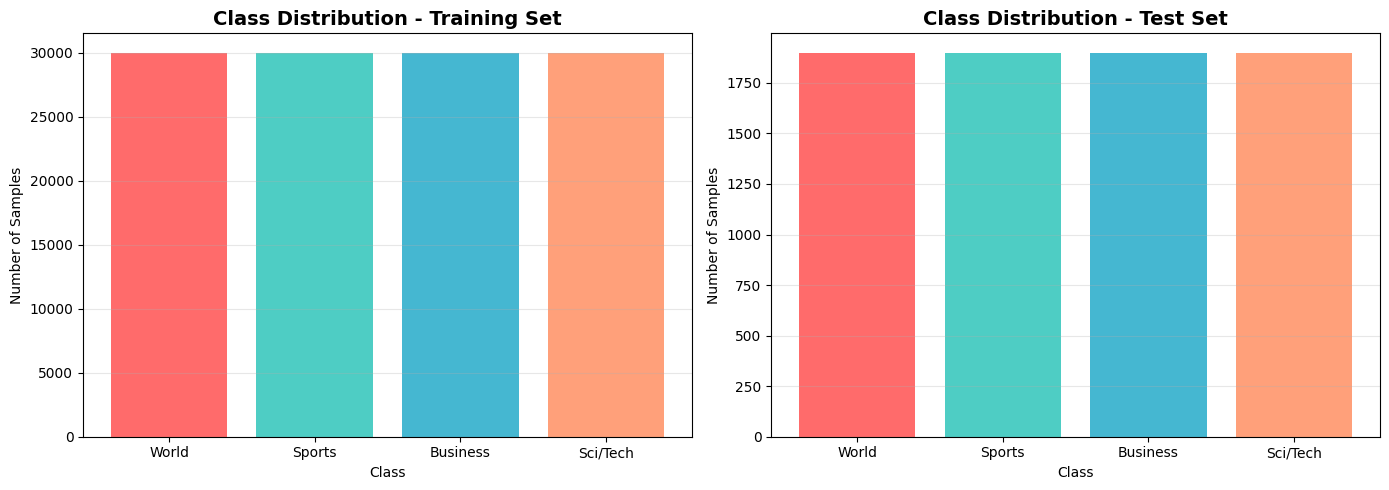

✓ Dataset is perfectly balanced across all classes


In [11]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


train_counts = train_df['Class Index'].value_counts().sort_index()
axes[0].bar([class_names[i] for i in train_counts.index], train_counts.values,
            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0].set_title('Class Distribution - Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', alpha=0.3)


test_counts = test_df['Class Index'].value_counts().sort_index()
axes[1].bar([class_names[i] for i in test_counts.index], test_counts.values,
            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[1].set_title('Class Distribution - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Samples')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Dataset is perfectly balanced across all classes")

 Text Length Analysis

In [12]:

train_df['combined_text'] = train_df['Title'] + ' ' + train_df['Description']
test_df['combined_text'] = test_df['Title'] + ' ' + test_df['Description']


train_df['text_length'] = train_df['combined_text'].apply(len)
train_df['word_count'] = train_df['combined_text'].apply(lambda x: len(str(x).split()))

print("Text Length Statistics:")
print(f"Mean character length: {train_df['text_length'].mean():.2f}")
print(f"Median character length: {train_df['text_length'].median():.2f}")
print(f"Mean word count: {train_df['word_count'].mean():.2f}")
print(f"Median word count: {train_df['word_count'].median():.2f}")

Text Length Statistics:
Mean character length: 236.46
Median character length: 232.00
Mean word count: 37.84
Median word count: 37.00


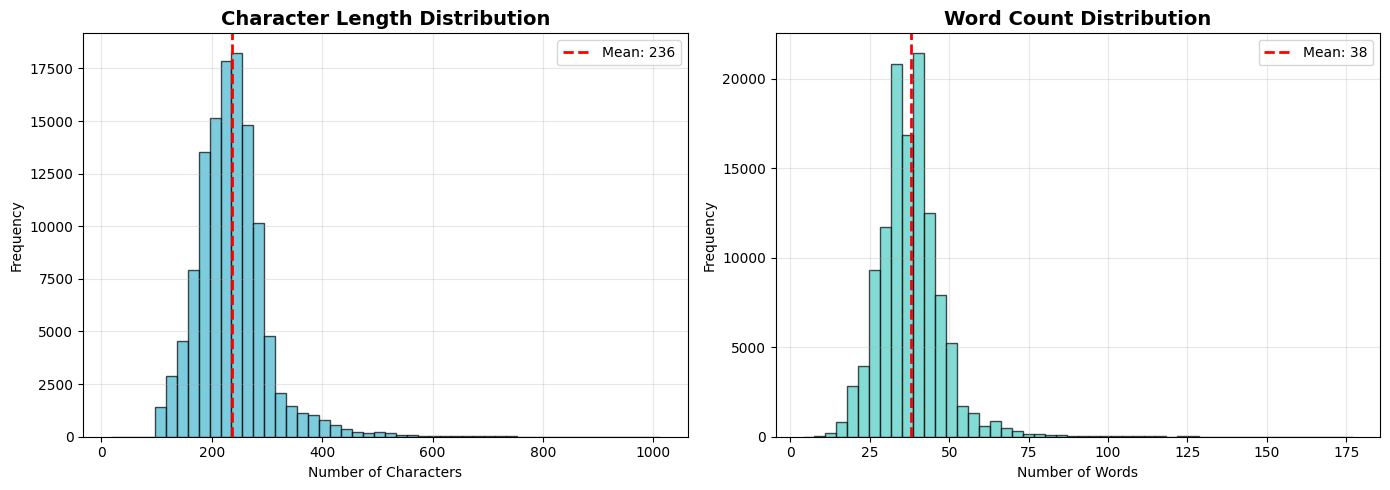

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].hist(train_df['text_length'], bins=50, color='#45B7D1', alpha=0.7, edgecolor='black')
axes[0].axvline(train_df['text_length'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {train_df["text_length"].mean():.0f}')
axes[0].set_title('Character Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)


axes[1].hist(train_df['word_count'], bins=50, color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1].axvline(train_df['word_count'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {train_df["word_count"].mean():.0f}')
axes[1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

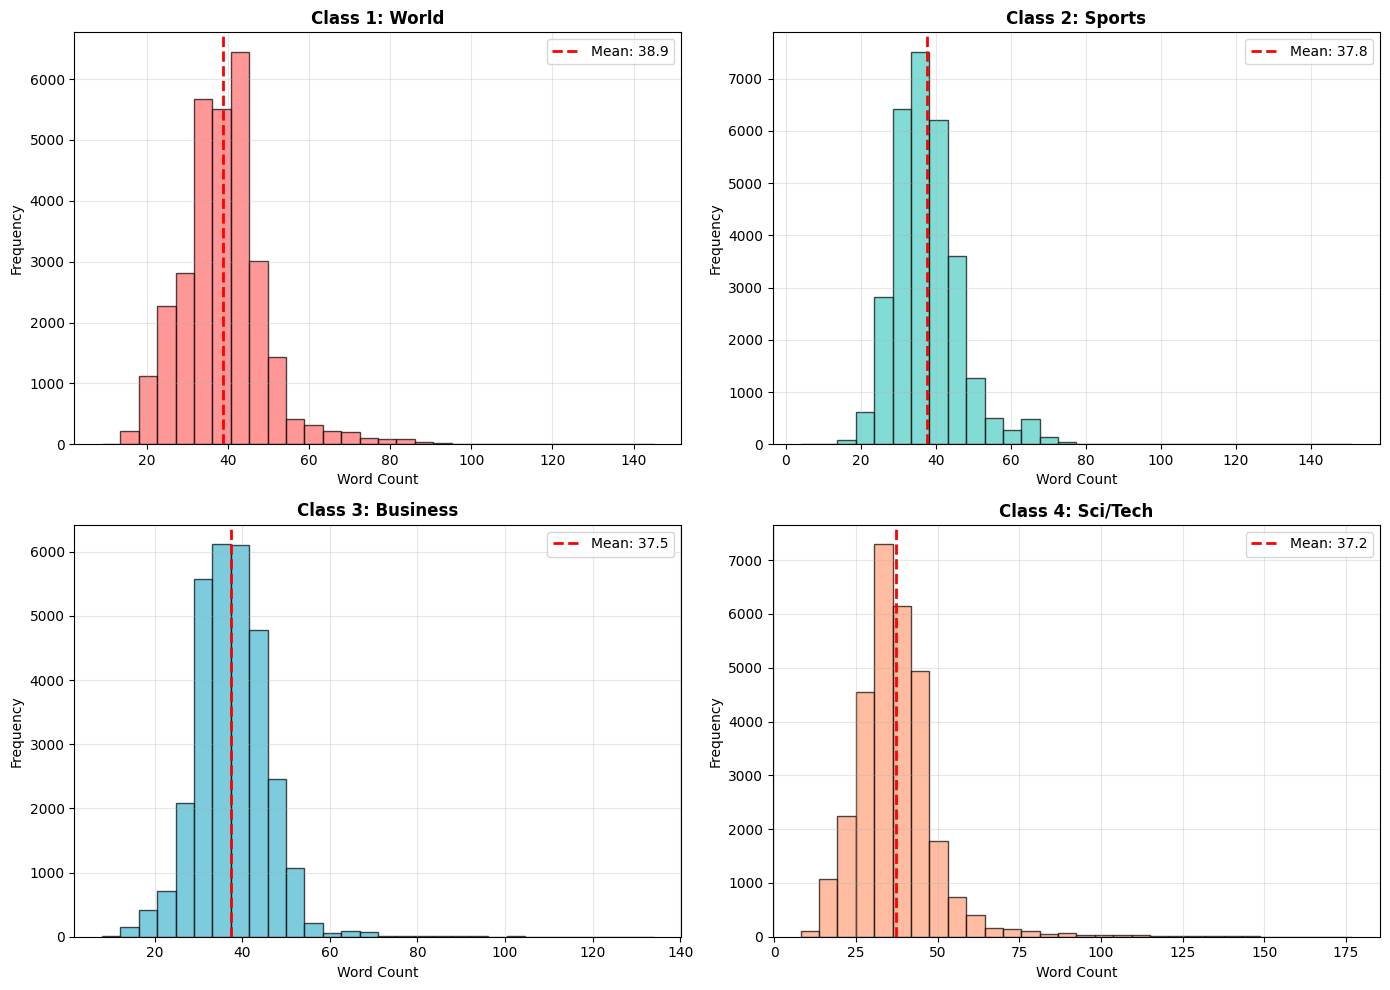

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (class_idx, class_name) in enumerate(class_names.items()):
    class_data = train_df[train_df['Class Index'] == class_idx]['word_count']
    axes[idx].hist(class_data, bins=30, color=colors[idx], alpha=0.7, edgecolor='black')
    axes[idx].axvline(class_data.mean(), color='red', linestyle='--',
                     linewidth=2, label=f'Mean: {class_data.mean():.1f}')
    axes[idx].set_title(f'Class {class_idx}: {class_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Word Count')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Sample Articles from Each Class

In [15]:
print("=" * 80)
print("SAMPLE ARTICLES FROM EACH CLASS")
print("=" * 80)

for class_idx, class_name in class_names.items():
    sample = train_df[train_df['Class Index'] == class_idx].iloc[0]
    print(f"\n{'─' * 80}")
    print(f"CLASS {class_idx}: {class_name.upper()}")
    print(f"{'─' * 80}")
    print(f"Title: {sample['Title']}")
    print(f"\nDescription: {sample['Description'][:200]}...")
    print()

SAMPLE ARTICLES FROM EACH CLASS

────────────────────────────────────────────────────────────────────────────────
CLASS 1: WORLD
────────────────────────────────────────────────────────────────────────────────
Title: Venezuelans Vote Early in Referendum on Chavez Rule (Reuters)

Description: Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to ...


────────────────────────────────────────────────────────────────────────────────
CLASS 2: SPORTS
────────────────────────────────────────────────────────────────────────────────
Title: Phelps, Thorpe Advance in 200 Freestyle (AP)

Description: AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final...


───────────────────────────────────────────────────

 Text Preprocessing Pipeline

### Shared Preprocessing Strategy
All embeddings will use a consistent base preprocessing approach:
1. Lowercase conversion
2. Remove special characters and numbers
3. Tokenization
4. Stopword removal
5. Lemmatization



In [16]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, keep_format='tokens'):
    """
    Preprocess text with options for different output formats.

    Args:
        text: Input text string
        keep_format: 'tokens' for list, 'text' for string

    Returns:
        Preprocessed text in requested format
    """

    text = text.lower()


    text = re.sub(r'http\S+|www\S+', '', text)

    text = re.sub(r'<.*?>', '', text)


    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)


    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    if keep_format == 'tokens':
        return tokens
    else:
        return ' '.join(tokens)

print("✓ Preprocessing function defined")

✓ Preprocessing function defined


In [17]:

sample_text = train_df['combined_text'].iloc[0]
print("Original text:")
print(sample_text[:200])
print("\nPreprocessed (tokens):")
print(preprocess_text(sample_text, keep_format='tokens')[:20])
print("\nPreprocessed (text):")
print(preprocess_text(sample_text, keep_format='text')[:200])

Original text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Preprocessed (tokens):
['wall', 'bear', 'claw', 'back', 'black', 'reuters', 'reuters', 'shortsellers', 'wall', 'street', 'dwindlingband', 'ultracynics', 'seeing', 'green']

Preprocessed (text):
wall bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green


In [18]:

print("Preprocessing training data...")
train_df['processed_tokens'] = train_df['combined_text'].apply(
    lambda x: preprocess_text(x, keep_format='tokens')
)
train_df['processed_text'] = train_df['processed_tokens'].apply(lambda x: ' '.join(x))

print("Preprocessing test data...")
test_df['processed_tokens'] = test_df['combined_text'].apply(
    lambda x: preprocess_text(x, keep_format='tokens')
)
test_df['processed_text'] = test_df['processed_tokens'].apply(lambda x: ' '.join(x))

print("✓ Preprocessing complete!")
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")

Preprocessing training data...
Preprocessing test data...
✓ Preprocessing complete!
Training samples: 120,000
Test samples: 7,600


 Vocabulary Analysis

In [19]:

all_tokens = [token for tokens in train_df['processed_tokens'] for token in tokens]
vocab = set(all_tokens)

print("Vocabulary Statistics:")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens (vocabulary size): {len(vocab):,}")
print(f"Average tokens per document: {len(all_tokens) / len(train_df):.2f}")


from collections import Counter
word_freq = Counter(all_tokens)
print("\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count:,}")

Vocabulary Statistics:
Total tokens: 2,892,799
Unique tokens (vocabulary size): 82,987
Average tokens per document: 24.11

Top 20 most common words:
  new: 21,220
  said: 19,995
  reuters: 17,243
  year: 11,520
  company: 10,052
  first: 9,048
  two: 8,925
  world: 8,637
  say: 7,671
  game: 7,552
  monday: 7,491
  wednesday: 7,361
  tuesday: 7,301
  oil: 7,236
  one: 7,208
  thursday: 7,175
  week: 6,811
  inc: 6,770
  friday: 6,738
  state: 6,601


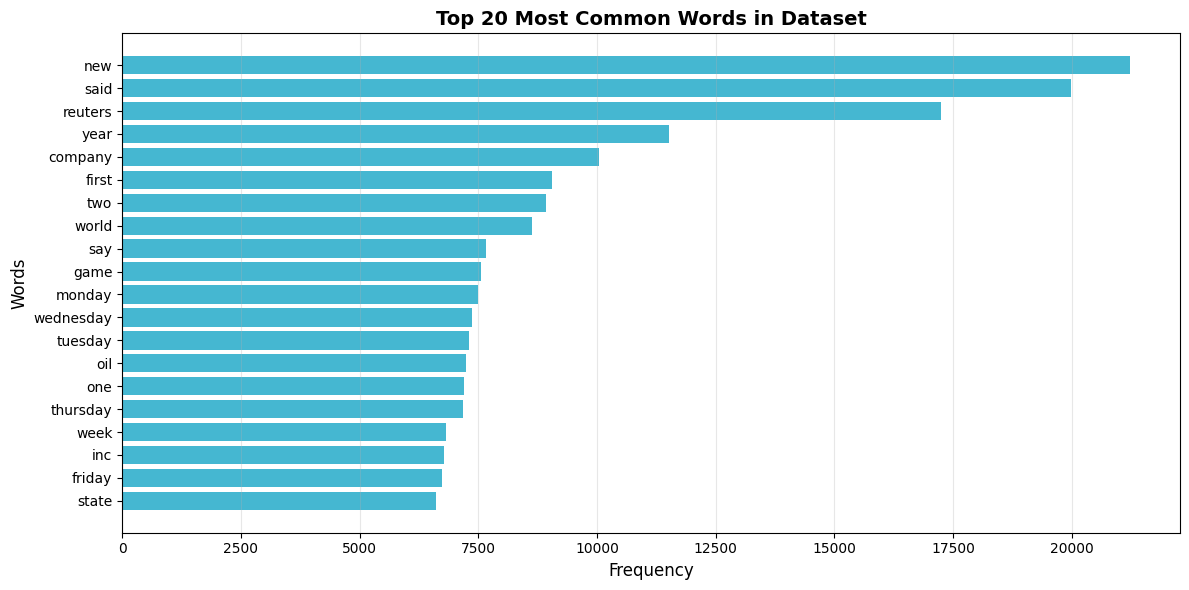

In [20]:

top_words = word_freq.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.barh(range(len(words)), counts, color='#45B7D1')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.title('Top 20 Most Common Words in Dataset', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

 Model Training and Evaluation Functions

In [27]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns
class_names = {
    1: 'World',
    2: 'Sports',
    3: 'Business',
    4: 'Sci/Tech'
}

def evaluate_model(model, X_test, y_test, embedding_name):
    """
    Evaluate model and return comprehensive metrics.
    """

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')


    print(f"\n{'='*60}")
    print(f"EVALUATION RESULTS - {embedding_name}")
    print(f"{'='*60}")
    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                                target_names=[f"{class_names[i+1]}" for i in range(4)]))


    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[class_names[i+1] for i in range(4)],
                yticklabels=[class_names[i+1] for i in range(4)],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - RNN with {embedding_name}',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [23]:

def plot_training_history(history, embedding_name):
    """
    Plot training and validation accuracy/loss curves.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))


    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'Model Accuracy - {embedding_name}', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)


    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'Model Loss - {embedding_name}', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

print("✓ Plotting function defined")

✓ Plotting function defined


In [1]:

results_summary = {}

print("✓ Dictionary to store results initialized")
print("✓ Results dictionary initialized and callbacks defined")

✓ Results dictionary initialized and callbacks defined


---
---

# EXPERIMENT 1: RNN with TF-IDF Features

---
---

 TF-IDF Feature Extraction

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a statistical measure that evaluates word importance in a document relative to a collection. For RNN compatibility, we'll use TF-IDF to create dense feature vectors.

In [2]:

import numpy as np
import pandas as pd


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


TFIDF_MAX_FEATURES = 5000
TFIDF_MAX_LEN = 100
tf.keras.backend.clear_session()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, keep_format='tokens'):
    """
    Preprocess text with options for different output formats.

    Args:
        text: Input text string
        keep_format: 'tokens' for list, 'text' for string

    Returns:
        Preprocessed text in requested format
    """

    text = text.lower()


    text = re.sub(r'http\S+|www\S+', '', text)


    text = re.sub(r'<.*?>', '', text)


    text = re.sub(r'[^a-zA-Z\s]', '', text)


    tokens = word_tokenize(text)


    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    if keep_format == 'tokens':
        return tokens
    else:
        return ' '.join(tokens)


train_df['combined_text'] = train_df['Title'] + ' ' + train_df['Description']
test_df['combined_text'] = test_df['Title'] + ' ' + test_df['Description']


train_df['processed_tokens'] = train_df['combined_text'].apply(
    lambda x: preprocess_text(x, keep_format='tokens')
)
train_df['processed_text'] = train_df['processed_tokens'].apply(lambda x: ' '.join(x))

test_df['processed_tokens'] = test_df['combined_text'].apply(
    lambda x: preprocess_text(x, keep_format='tokens')
)
test_df['processed_text'] = test_df['processed_tokens'].apply(lambda x: ' '.join(x))


y_train_full = train_df['Class Index'].values - 1
y_test = test_df['Class Index'].values - 1


X_train_text_full = train_df['processed_text'].values
X_train_tokens_full = train_df['processed_tokens'].values

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text_full, y_train_full,
    test_size=0.15,
    random_state=SEED,
    stratify=y_train_full
)

X_train_tokens, X_val_tokens, _, _ = train_test_split(
    X_train_tokens_full, y_train_full,
    test_size=0.15,
    random_state=SEED,
    stratify=y_train_full
)

X_test_text = test_df['processed_text'].values
X_test_tokens = test_df['processed_tokens'].values

print("Data split completed:")
print(f"Training samples: {len(X_train_text):,}")
print(f"Validation samples: {len(X_val_text):,}")
print(f"Test samples: {len(X_test_text):,}")
print(f"\nNumber of classes: {len(np.unique(y_train))}")


tfidf_vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES)


X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_val_tfidf = tfidf_vectorizer.transform(X_val_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

print("TF-IDF Vectorization complete:")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_val_tfidf shape: {X_val_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")



model_tfidf = Sequential([
    Dense(512, activation='relu', input_shape=(TFIDF_MAX_FEATURES,)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_tfidf.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Training Dense model with TF-IDF features...")

print(f"Callbacks defined before fit: early_stopping={early_stopping is not None}, reduce_lr={reduce_lr is not None}")

history_tfidf = model_tfidf.fit(
    X_train_tfidf, y_train,
    validation_data=(X_val_tfidf, y_val),
    epochs=10,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✓ Training completed!")

Data split completed:
Training samples: 102,000
Validation samples: 18,000
Test samples: 7,600

Number of classes: 4
TF-IDF Vectorization complete:
X_train_tfidf shape: (102000, 5000)
X_val_tfidf shape: (18000, 5000)
X_test_tfidf shape: (7600, 5000)
Training Dense model with TF-IDF features...
Callbacks defined before fit: early_stopping=True, reduce_lr=True


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.8173 - loss: 0.5618 - val_accuracy: 0.9119 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.9159 - loss: 0.2407 - val_accuracy: 0.9122 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.9315 - loss: 0.1954 - val_accuracy: 0.9104 - val_loss: 0.2764 - learning_rate: 0.0010
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9482 - loss: 0.1499
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
399/399 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.9483 - loss: 0.1499 - val_accuracy: 0.9089 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.9656 - loss: 0.1006 - val_accuracy: 0.9099 - val_loss: 0.3456 - learning_rate: 5.0000e-04
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.9775 -

In [3]:
tfidf_vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES)


X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_val_tfidf = tfidf_vectorizer.transform(X_val_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

print("TF-IDF Vectorization complete:")
print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_val_tfidf shape: {X_val_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")

TF-IDF Vectorization complete:
X_train_tfidf shape: (102000, 5000)
X_val_tfidf shape: (18000, 5000)
X_test_tfidf shape: (7600, 5000)


In [4]:
X_train_tfidf_seq = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_val_tfidf_seq = X_val_tfidf.reshape(X_val_tfidf.shape[0], X_val_tfidf.shape[1], 1)
X_test_tfidf_seq = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

print(f"Reshaped for RNN:")
print(f"Training shape: {X_train_tfidf_seq.shape}")
print(f"Validation shape: {X_val_tfidf_seq.shape}")
print(f"Test shape: {X_test_tfidf_seq.shape}")

Reshaped for RNN:
Training shape: (102000, 5000, 1)
Validation shape: (18000, 5000, 1)
Test shape: (7600, 5000, 1)


 Build RNN Model with TF-IDF

In [6]:
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout


tf.keras.backend.clear_session()


model_rnn_tfidf = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(TFIDF_MAX_FEATURES, 1)),
    Dropout(0.3),
    SimpleRNN(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_rnn_tfidf.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("RNN Model with TF-IDF:")
model_rnn_tfidf.summary()

RNN Model with TF-IDF:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 5000, 64)       │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,700 (37.89 KB)

 Trainable params: 9,700 (37.89 KB)

 Non-trainable params: 0 (0.00 B)

## 6.3 Evaluate RNN with TF-IDF

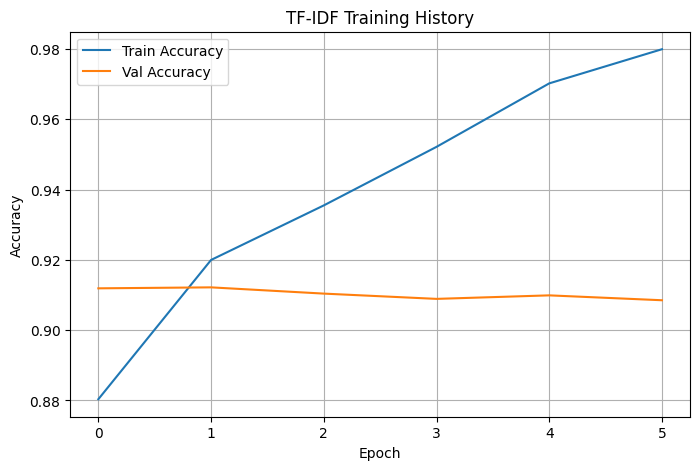

In [14]:
plot_training_history(history_tfidf, "TF-IDF")


EVALUATION RESULTS - TF-IDF

Accuracy:  0.2407
Precision: 0.2429
Recall:    0.2407
F1-Score:  0.2256

Classification Report:
              precision    recall  f1-score   support

       World       0.23      0.29      0.26      1900
      Sports       0.23      0.33      0.27      1900
    Business       0.25      0.07      0.10      1900
    Sci/Tech       0.26      0.27      0.27      1900

    accuracy                           0.24      7600
   macro avg       0.24      0.24      0.23      7600
weighted avg       0.24      0.24      0.23      7600



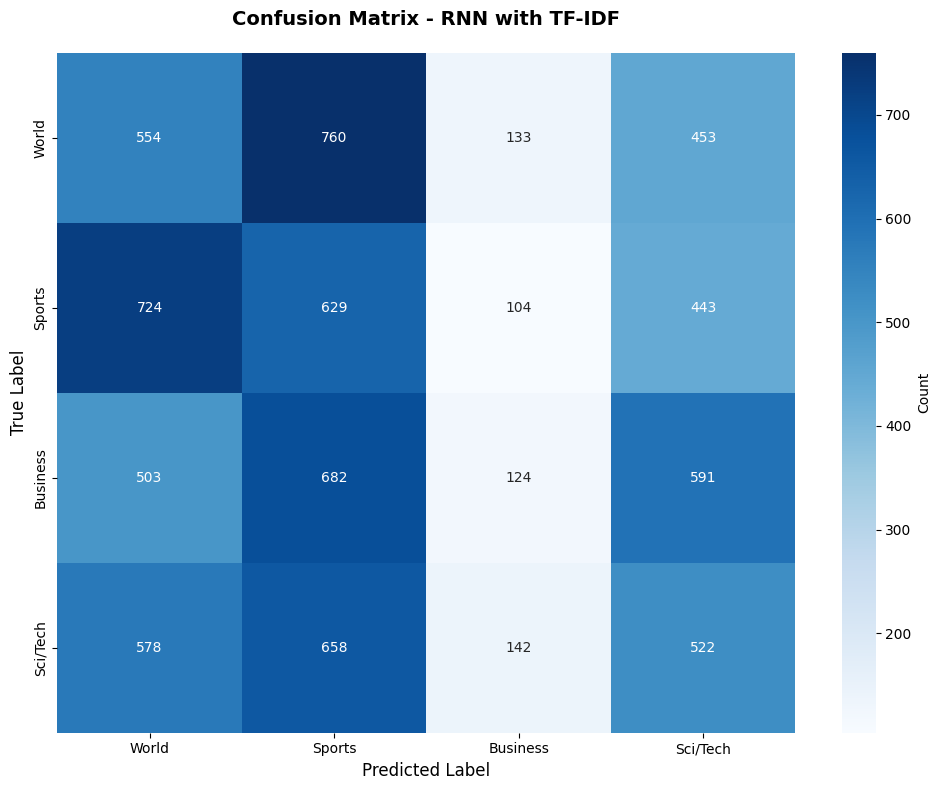

In [30]:
results_tfidf = evaluate_model(model_rnn_tfidf, X_test_tfidf_seq, y_test, "TF-IDF")
results_summary['TF-IDF'] = results_tfidf

---
---

# EXPERIMENT 2: RNN with Word2Vec Skip-gram Embeddings

---
---

 Train Word2Vec Skip-gram Model

**Skip-gram** predicts context words from a target word, making it effective for capturing word semantics.

In [46]:


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


W2V_EMBEDDING_DIM = 100
W2V_MAX_LEN = 60


tokenizer_w2v = Tokenizer(num_words=W2V_MAX_VOCAB, oov_token="<unk>")
tokenizer_w2v.fit_on_texts(X_train_tokens)


X_train_pad_sg = pad_sequences(
    tokenizer_w2v.texts_to_sequences(X_train_tokens),
    maxlen=W2V_MAX_LEN,
    padding='post'
)
X_val_pad_sg = pad_sequences(
    tokenizer_w2v.texts_to_sequences(X_val_tokens),
    maxlen=W2V_MAX_LEN,
    padding='post'
)
X_test_pad_sg = pad_sequences(
    tokenizer_w2v.texts_to_sequences(X_test_tokens),
    maxlen=W2V_MAX_LEN,
    padding='post'
)

print(f"✓ Tokenizer fitted and sequences padded for Word2Vec Skip-gram")
print(f"  Training sequences shape: {X_train_pad_sg.shape}")
print(f"  Validation sequences shape: {X_val_pad_sg.shape}")
print(f"  Test sequences shape: {X_test_pad_sg.shape}")


✓ Tokenizer fitted and sequences padded for Word2Vec Skip-gram
  Training sequences shape: (102000, 60)
  Validation sequences shape: (18000, 60)
  Test sequences shape: (7600, 60)


In [34]:
W2V_EMBEDDING_DIM = 100
W2V_WINDOW = 5
W2V_MIN_COUNT = 2
W2V_MAX_VOCAB = 20000
W2V_MAX_LEN = 60

print("Word2Vec Configuration:")
print(f"  Embedding dimension: {W2V_EMBEDDING_DIM}")
print(f"  Window size: {W2V_WINDOW}")
print(f"  Min count: {W2V_MIN_COUNT}")
print(f"  Max vocabulary: {W2V_MAX_VOCAB:,}")
print(f"  Sequence length: {W2V_MAX_LEN}")

Word2Vec Configuration:
  Embedding dimension: 100
  Window size: 5
  Min count: 2
  Max vocabulary: 20,000
  Sequence length: 60


In [47]:
train_sentences = list(X_train_tokens)

print(f"Training Skip-gram Word2Vec model on {len(train_sentences):,} documents...")


w2v_skipgram = Word2Vec(
    sentences=train_sentences,
    vector_size=W2V_EMBEDDING_DIM,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=4,
    sg=1,
    seed=SEED,
    epochs=10
)

print(f"\n✓ Skip-gram model trained")
print(f"Vocabulary size: {len(w2v_skipgram.wv):,}")

Training Skip-gram Word2Vec model on 102,000 documents...

✓ Skip-gram model trained
Vocabulary size: 41,240


In [37]:
test_words = ['government', 'football', 'market', 'technology']

print("Word2Vec Skip-gram - Similar Words:")
print("=" * 50)
for word in test_words:
    if word in w2v_skipgram.wv:
        similar = w2v_skipgram.wv.most_similar(word, topn=5)
        print(f"\n{word.upper()}:")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.4f}")

Word2Vec Skip-gram - Similar Words:

GOVERNMENT:
  reportshowed: 0.6587
  keptup: 0.6575
  authority: 0.6475
  thegovernment: 0.6441
  obliged: 0.6397

FOOTBALL:
  coach: 0.7169
  ucf: 0.7168
  coached: 0.6977
  reprimand: 0.6827
  claymore: 0.6798

MARKET:
  sector: 0.6561
  smallcaps: 0.6340
  smallcap: 0.6064
  ebbing: 0.6026
  hanes: 0.6015

TECHNOLOGY:
  knowhow: 0.6573
  adaptable: 0.6573
  perpendicular: 0.6477
  strainedsilicon: 0.6448
  digitalrights: 0.6448


 Create Embedding Matrix and Sequences

In [44]:
from tensorflow.keras.layers import GRU, Embedding

model_rnn_skipgram = Sequential(
    [
        Embedding(
            input_dim=vocab_size_sg,
            output_dim=W2V_EMBEDDING_DIM,
            weights=[embedding_matrix_sg],
            input_length=W2V_MAX_LEN,
            trainable=False
        ),
        GRU(64, return_sequences=True),
        Dropout(0.3),
        GRU(32),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(4, activation='softmax'),
    ]
)

In [48]:
word_index = tokenizer_w2v.word_index
vocab_size_sg = min(len(word_index) + 1, W2V_MAX_VOCAB)

embedding_matrix_sg = np.zeros((vocab_size_sg, W2V_EMBEDDING_DIM))

for word, idx in word_index.items():
    if idx < W2V_MAX_VOCAB:
        if word in w2v_skipgram.wv:
            embedding_matrix_sg[idx] = w2v_skipgram.wv[word]
        else:

            embedding_matrix_sg[idx] = np.random.uniform(-0.25, 0.25, W2V_EMBEDDING_DIM)

print(f"\n✓ Embedding matrix created")
print(f"Embedding matrix shape: {embedding_matrix_sg.shape}")


✓ Embedding matrix created
Embedding matrix shape: (20000, 100)


 Build RNN Model with Skip-gram Embeddings

In [51]:
tf.keras.backend.clear_session()


model_rnn_skipgram = Sequential([
    Embedding(
        input_dim=vocab_size_sg,
        output_dim=W2V_EMBEDDING_DIM,
        weights=[embedding_matrix_sg],
        input_length=W2V_MAX_LEN,
        trainable=False
    ),
    SimpleRNN(128, return_sequences=True),
    Dropout(0.3),
    SimpleRNN(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_rnn_skipgram.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("RNN Model with Skip-gram Embeddings:")
model_rnn_skipgram.summary()

RNN Model with Skip-gram Embeddings:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

 Train RNN with Skip-gram

In [52]:
print("Training RNN with Skip-gram embeddings...\n")

history_skipgram = model_rnn_skipgram.fit(
    X_train_pad_sg, y_train,
    validation_data=(X_val_pad_sg, y_val),
    epochs=8,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✓ Training completed!")

Training RNN with Skip-gram embeddings...

Epoch 1/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 73s 176ms/step - accuracy: 0.5914 - loss: 0.9310 - val_accuracy: 0.6792 - val_loss: 0.7429 - learning_rate: 0.0010
Epoch 2/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.7291 - loss: 0.7048 - val_accuracy: 0.7742 - val_loss: 0.7050 - learning_rate: 0.0010
Epoch 3/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 81s 175ms/step - accuracy: 0.7727 - loss: 0.6456 - val_accuracy: 0.2500 - val_loss: 1.3866 - learning_rate: 0.0010
Epoch 4/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 70s 176ms/step - accuracy: 0.2521 - loss: 1.3875 - val_accuracy: 0.2500 - val_loss: 1.3864 - learning_rate: 0.0010
Epoch 5/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2505 - loss: 1.3867
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
399/399 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.2505 - loss: 1.3867 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 6/8
399/399 ━━━━━━━━━━━━━━━━

Evaluate RNN with Skip-gram

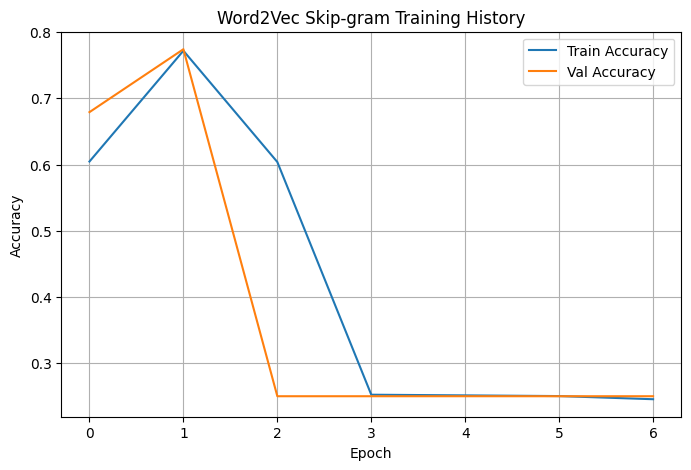

In [53]:
# Plot training history
plot_training_history(history_skipgram, "Word2Vec Skip-gram")


EVALUATION RESULTS - Word2Vec Skip-gram

Accuracy:  0.7628
Precision: 0.7909
Recall:    0.7628
F1-Score:  0.7661

Classification Report:
              precision    recall  f1-score   support

       World       0.76      0.69      0.72      1900
      Sports       0.96      0.74      0.84      1900
    Business       0.62      0.89      0.73      1900
    Sci/Tech       0.82      0.73      0.77      1900

    accuracy                           0.76      7600
   macro avg       0.79      0.76      0.77      7600
weighted avg       0.79      0.76      0.77      7600



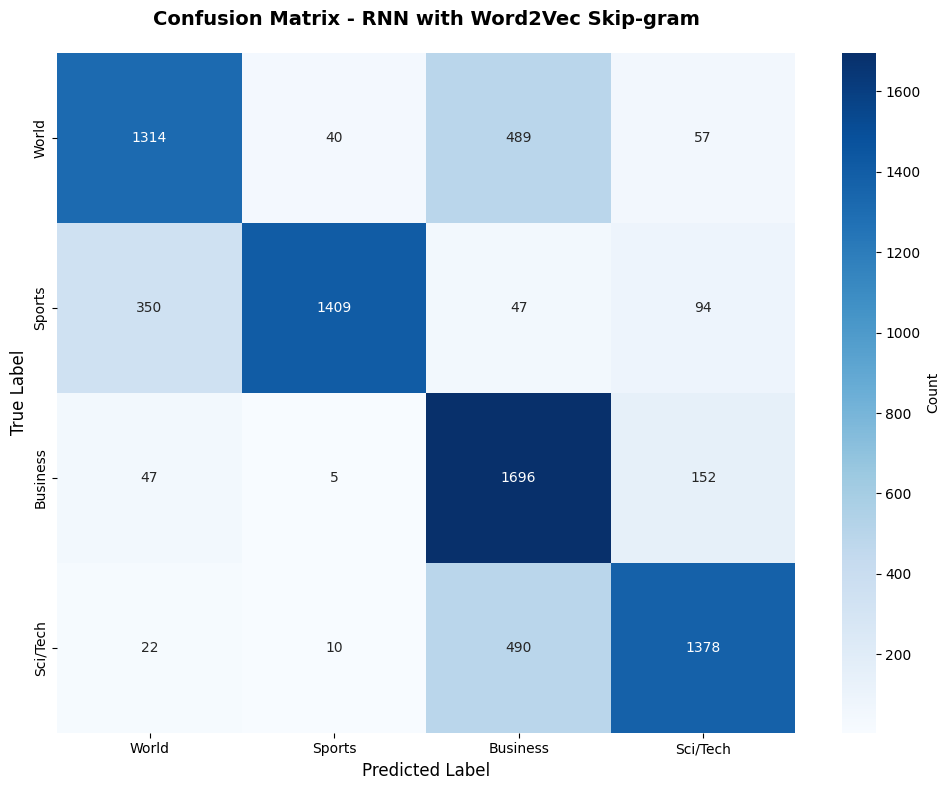

In [54]:
# Evaluate on test set
results_skipgram = evaluate_model(model_rnn_skipgram, X_test_pad_sg, y_test, "Word2Vec Skip-gram")
results_summary['Skip-gram'] = results_skipgram

---
---

# EXPERIMENT 3: RNN with Word2Vec CBOW Embeddings

---
---

 Train Word2Vec CBOW Model

**CBOW (Continuous Bag of Words)** predicts the target word from context words, making it faster and better for frequent words.

In [55]:
print(f"Training CBOW Word2Vec model on {len(train_sentences):,} documents...")


w2v_cbow = Word2Vec(
    sentences=train_sentences,
    vector_size=W2V_EMBEDDING_DIM,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=4,
    sg=0,
    seed=SEED,
    epochs=10
)

print(f"\n✓ CBOW model trained")
print(f"Vocabulary size: {len(w2v_cbow.wv):,}")

Training CBOW Word2Vec model on 102,000 documents...

✓ CBOW model trained
Vocabulary size: 41,240


In [56]:
print("Word2Vec CBOW - Similar Words:")
print("=" * 50)
for word in test_words:
    if word in w2v_cbow.wv:
        similar = w2v_cbow.wv.most_similar(word, topn=5)
        print(f"\n{word.upper()}:")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.4f}")

Word2Vec CBOW - Similar Words:

GOVERNMENT:
  authority: 0.5753
  administration: 0.5013
  congress: 0.4942
  politician: 0.4848
  govt: 0.4816

FOOTBALL:
  coaching: 0.6349
  soccer: 0.6328
  basketball: 0.6272
  ncaa: 0.5984
  english: 0.5979

MARKET:
  sector: 0.6301
  recovery: 0.4853
  economy: 0.4776
  currency: 0.4682
  investor: 0.4604

TECHNOLOGY:
  capability: 0.6006
  chip: 0.5828
  component: 0.5784
  technique: 0.5690
  architecture: 0.5640


Create CBOW Embedding Matrix

In [57]:
X_train_pad_cbow = X_train_pad_sg.copy()
X_val_pad_cbow = X_val_pad_sg.copy()
X_test_pad_cbow = X_test_pad_sg.copy()


embedding_matrix_cbow = np.zeros((vocab_size_sg, W2V_EMBEDDING_DIM))

for word, idx in word_index.items():
    if idx < W2V_MAX_VOCAB:
        if word in w2v_cbow.wv:
            embedding_matrix_cbow[idx] = w2v_cbow.wv[word]
        else:
            embedding_matrix_cbow[idx] = np.random.uniform(-0.25, 0.25, W2V_EMBEDDING_DIM)

print(f"✓ CBOW embedding matrix created")
print(f"Embedding matrix shape: {embedding_matrix_cbow.shape}")

✓ CBOW embedding matrix created
Embedding matrix shape: (20000, 100)


 Build RNN Model with CBOW Embeddings

In [58]:
tf.keras.backend.clear_session()


model_rnn_cbow = Sequential([
    Embedding(
        input_dim=vocab_size_sg,
        output_dim=W2V_EMBEDDING_DIM,
        weights=[embedding_matrix_cbow],
        input_length=W2V_MAX_LEN,
        trainable=False
    ),
    SimpleRNN(128, return_sequences=True),
    Dropout(0.3),
    SimpleRNN(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_rnn_cbow.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("RNN Model with CBOW Embeddings:")
model_rnn_cbow.summary()

RNN Model with CBOW Embeddings:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

 Train RNN with CBOW

In [59]:
print("Training RNN with CBOW embeddings...\n")

history_cbow = model_rnn_cbow.fit(
    X_train_pad_cbow, y_train,
    validation_data=(X_val_pad_cbow, y_val),
    epochs=8,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✓ Training completed!")

Training RNN with CBOW embeddings...

Epoch 1/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 73s 175ms/step - accuracy: 0.5603 - loss: 1.0491 - val_accuracy: 0.4311 - val_loss: 1.2209 - learning_rate: 0.0010
Epoch 2/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 69s 172ms/step - accuracy: 0.5042 - loss: 1.0490 - val_accuracy: 0.7896 - val_loss: 0.6148 - learning_rate: 0.0010
Epoch 3/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 69s 174ms/step - accuracy: 0.7677 - loss: 0.6908 - val_accuracy: 0.7119 - val_loss: 0.7434 - learning_rate: 0.0010
Epoch 4/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 68s 170ms/step - accuracy: 0.6876 - loss: 0.7689 - val_accuracy: 0.6753 - val_loss: 0.7609 - learning_rate: 0.0010
Epoch 5/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6712 - loss: 0.7735
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
399/399 ━━━━━━━━━━━━━━━━━━━━ 69s 174ms/step - accuracy: 0.6711 - loss: 0.7735 - val_accuracy: 0.6705 - val_loss: 0.7610 - learning_rate: 0.0010
Epoch 6/8
399/399 ━━━━━━━━━━━━━━━━━━━━ 

 Evaluate RNN with CBOW

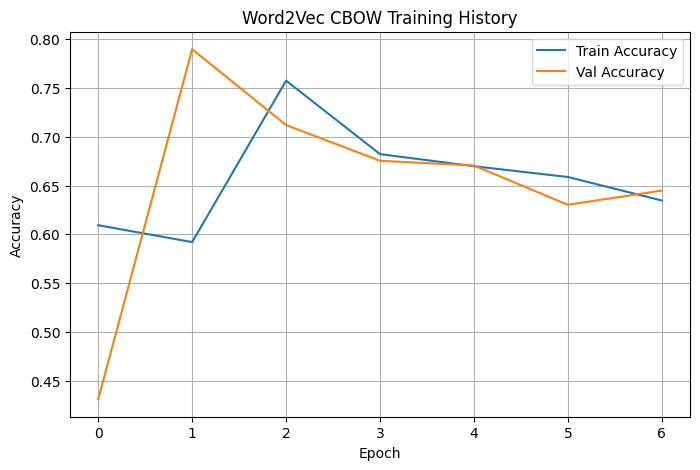

In [60]:
# Plot training history
plot_training_history(history_cbow, "Word2Vec CBOW")


EVALUATION RESULTS - Word2Vec CBOW

Accuracy:  0.7820
Precision: 0.7839
Recall:    0.7820
F1-Score:  0.7820

Classification Report:
              precision    recall  f1-score   support

       World       0.81      0.81      0.81      1900
      Sports       0.92      0.89      0.91      1900
    Business       0.70      0.78      0.74      1900
    Sci/Tech       0.71      0.65      0.68      1900

    accuracy                           0.78      7600
   macro avg       0.78      0.78      0.78      7600
weighted avg       0.78      0.78      0.78      7600



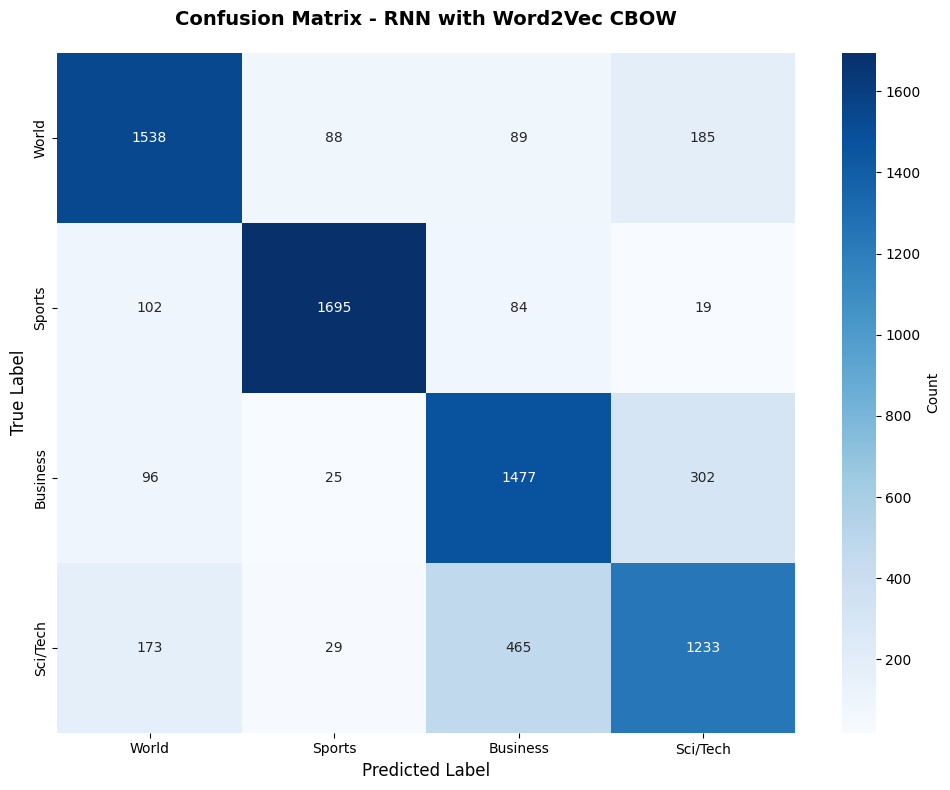

In [61]:
# Evaluate on test set
results_cbow = evaluate_model(model_rnn_cbow, X_test_pad_cbow, y_test, "Word2Vec CBOW")
results_summary['CBOW'] = results_cbow

---
---

# EXPERIMENT 4: RNN with Pre-trained GloVe Embeddings

---
---

 Load Pre-trained GloVe Embeddings

**GloVe (Global Vectors)** are pre-trained embeddings that capture global corpus statistics.

In [62]:
GLOVE_DIM = 100
GLOVE_MAX_LEN = 60

print("Loading pre-trained GloVe embeddings...")
print("This may take a few minutes on first run...\n")

try:

    glove_model = api.load(f"glove-wiki-gigaword-{GLOVE_DIM}")
    print(f"\n✓ GloVe embeddings loaded")
    print(f"Vocabulary size: {len(glove_model):,}")
except:
    print("Error loading GloVe. Skipping this experiment.")
    glove_model = None

Loading pre-trained GloVe embeddings...
This may take a few minutes on first run...

Error loading GloVe. Skipping this experiment.


In [63]:
if glove_model is not None:

    print("GloVe - Similar Words:")
    print("=" * 50)
    for word in test_words:
        if word in glove_model:
            similar = glove_model.most_similar(word, topn=5)
            print(f"\n{word.upper()}:")
            for sim_word, score in similar:
                print(f"  {sim_word}: {score:.4f}")

 Create GloVe Embedding Matrix

In [64]:
if glove_model is not None:

    X_train_pad_glove = X_train_pad_sg.copy()
    X_val_pad_glove = X_val_pad_sg.copy()
    X_test_pad_glove = X_test_pad_sg.copy()


    embedding_matrix_glove = np.zeros((vocab_size_sg, GLOVE_DIM))

    hits = 0
    misses = 0

    for word, idx in word_index.items():
        if idx < W2V_MAX_VOCAB:
            if word in glove_model:
                embedding_matrix_glove[idx] = glove_model[word]
                hits += 1
            else:
                embedding_matrix_glove[idx] = np.random.uniform(-0.25, 0.25, GLOVE_DIM)
                misses += 1

    print(f"\n✓ GloVe embedding matrix created")
    print(f"Embedding matrix shape: {embedding_matrix_glove.shape}")
    print(f"Words found in GloVe: {hits:,} ({hits/(hits+misses)*100:.2f}%)")
    print(f"Words not found: {misses:,}")

 Build RNN Model with GloVe Embeddings

In [65]:
if glove_model is not None:

    tf.keras.backend.clear_session()


    model_rnn_glove = Sequential([
        Embedding(
            input_dim=vocab_size_sg,
            output_dim=GLOVE_DIM,
            weights=[embedding_matrix_glove],
            input_length=GLOVE_MAX_LEN,
            trainable=False
        ),
        SimpleRNN(128, return_sequences=True),
        Dropout(0.3),
        SimpleRNN(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='softmax')
    ])

    model_rnn_glove.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("RNN Model with GloVe Embeddings:")
    model_rnn_glove.summary()

 Train RNN with GloVe

In [66]:
if glove_model is not None:
    print("Training RNN with GloVe embeddings...\n")

    history_glove = model_rnn_glove.fit(
        X_train_pad_glove, y_train,
        validation_data=(X_val_pad_glove, y_val),
        epochs=8,
        batch_size=256,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    print("\n✓ Training completed!")

 Evaluate RNN with GloVe

In [67]:
if glove_model is not None:

    plot_training_history(history_glove, "GloVe")

In [68]:
if glove_model is not None:

    results_glove = evaluate_model(model_rnn_glove, X_test_pad_glove, y_test, "GloVe")
    results_summary['GloVe'] = results_glove

 Results Comparison Table

In [69]:
results_df = pd.DataFrame({
    'Embedding': list(results_summary.keys()),
    'Accuracy': [results_summary[k]['accuracy'] for k in results_summary.keys()],
    'Precision': [results_summary[k]['precision'] for k in results_summary.keys()],
    'Recall': [results_summary[k]['recall'] for k in results_summary.keys()],
    'F1-Score': [results_summary[k]['f1_score'] for k in results_summary.keys()]
})


results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("FINAL RESULTS COMPARISON - RNN MODEL")
print("="*80)
print("\n", results_df.to_string(index=False))
print("\n" + "="*80)


best_embedding = results_df.iloc[0]['Embedding']
best_accuracy = results_df.iloc[0]['Accuracy']
print(f"\n🏆 Best Performance: RNN with {best_embedding} (Accuracy: {best_accuracy:.4f})")
print("="*80)


FINAL RESULTS COMPARISON - RNN MODEL

 Embedding  Accuracy  Precision   Recall  F1-Score
     CBOW  0.781974   0.783933 0.781974  0.782026
Skip-gram  0.762763   0.790869 0.762763  0.766140
   TF-IDF  0.240658   0.242921 0.240658  0.225550


🏆 Best Performance: RNN with CBOW (Accuracy: 0.7820)


In [70]:
results_df.to_csv('rnn_results.csv', index=False)
print("\n✓ Results saved to 'rnn_results.csv'")


✓ Results saved to 'rnn_results.csv'


Visual Comparison of Results

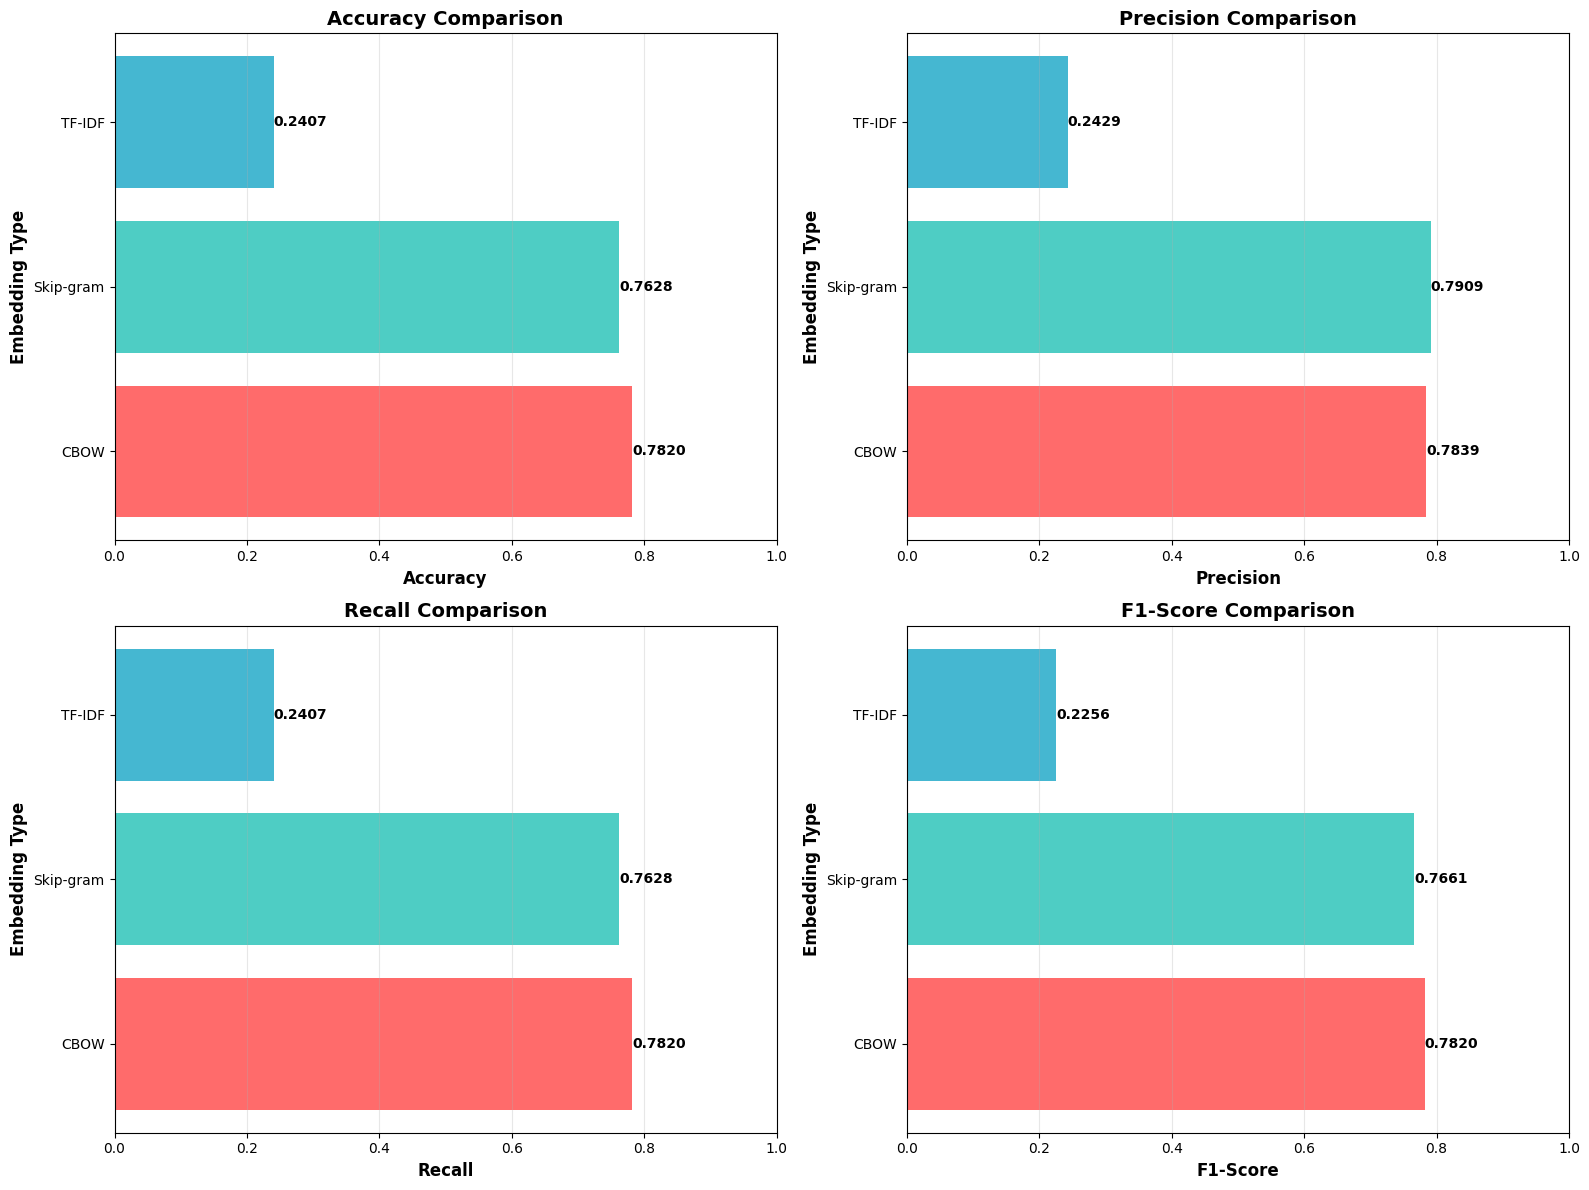

✓ Comparison plot saved as 'rnn_metrics_comparison.png'


In [71]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (ax, metric) in enumerate(zip(axes.flatten(), metrics)):
    values = results_df[metric].values
    bars = ax.barh(results_df['Embedding'], values, color=colors_palette[:len(results_df)])


    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left', va='center', fontsize=10, fontweight='bold')

    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Embedding Type', fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('rnn_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved as 'rnn_metrics_comparison.png'")

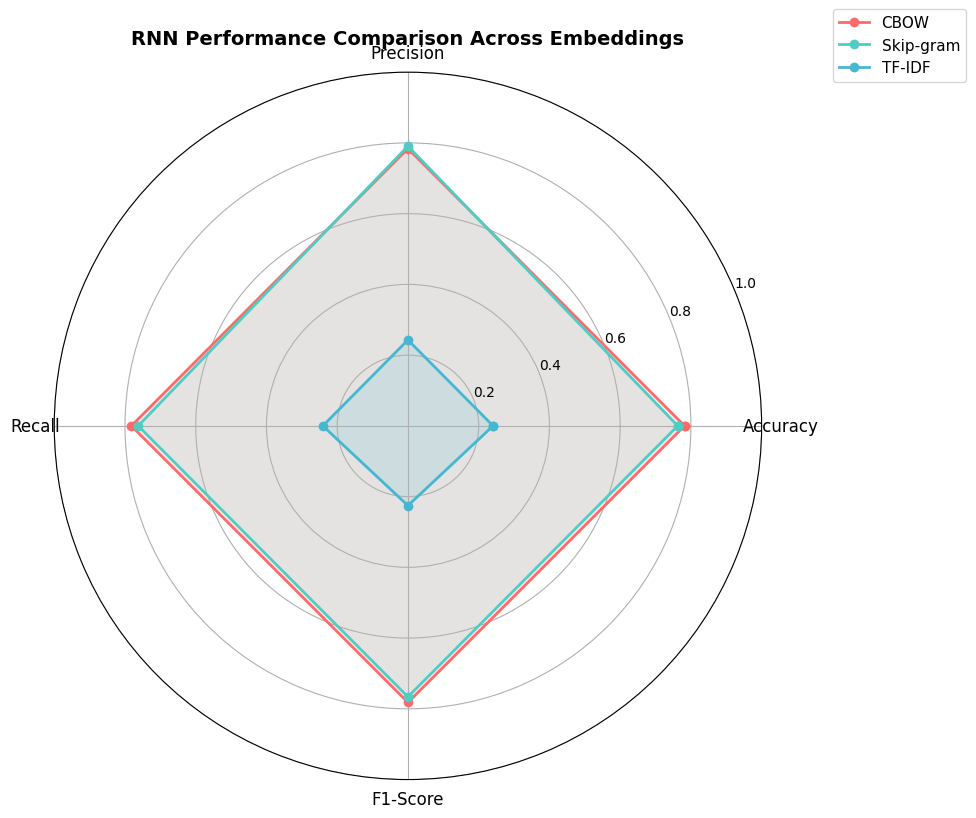

✓ Radar chart saved as 'rnn_radar_comparison.png'


In [72]:
from math import pi

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for idx, embedding in enumerate(results_df['Embedding']):
    values = results_df[results_df['Embedding'] == embedding][categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=embedding, color=colors_palette[idx])
    ax.fill(angles, values, alpha=0.15, color=colors_palette[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.set_title('RNN Performance Comparison Across Embeddings',
             size=14, fontweight='bold', pad=20)
ax.grid(True)

plt.tight_layout()
plt.savefig('rnn_radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Radar chart saved as 'rnn_radar_comparison.png'")

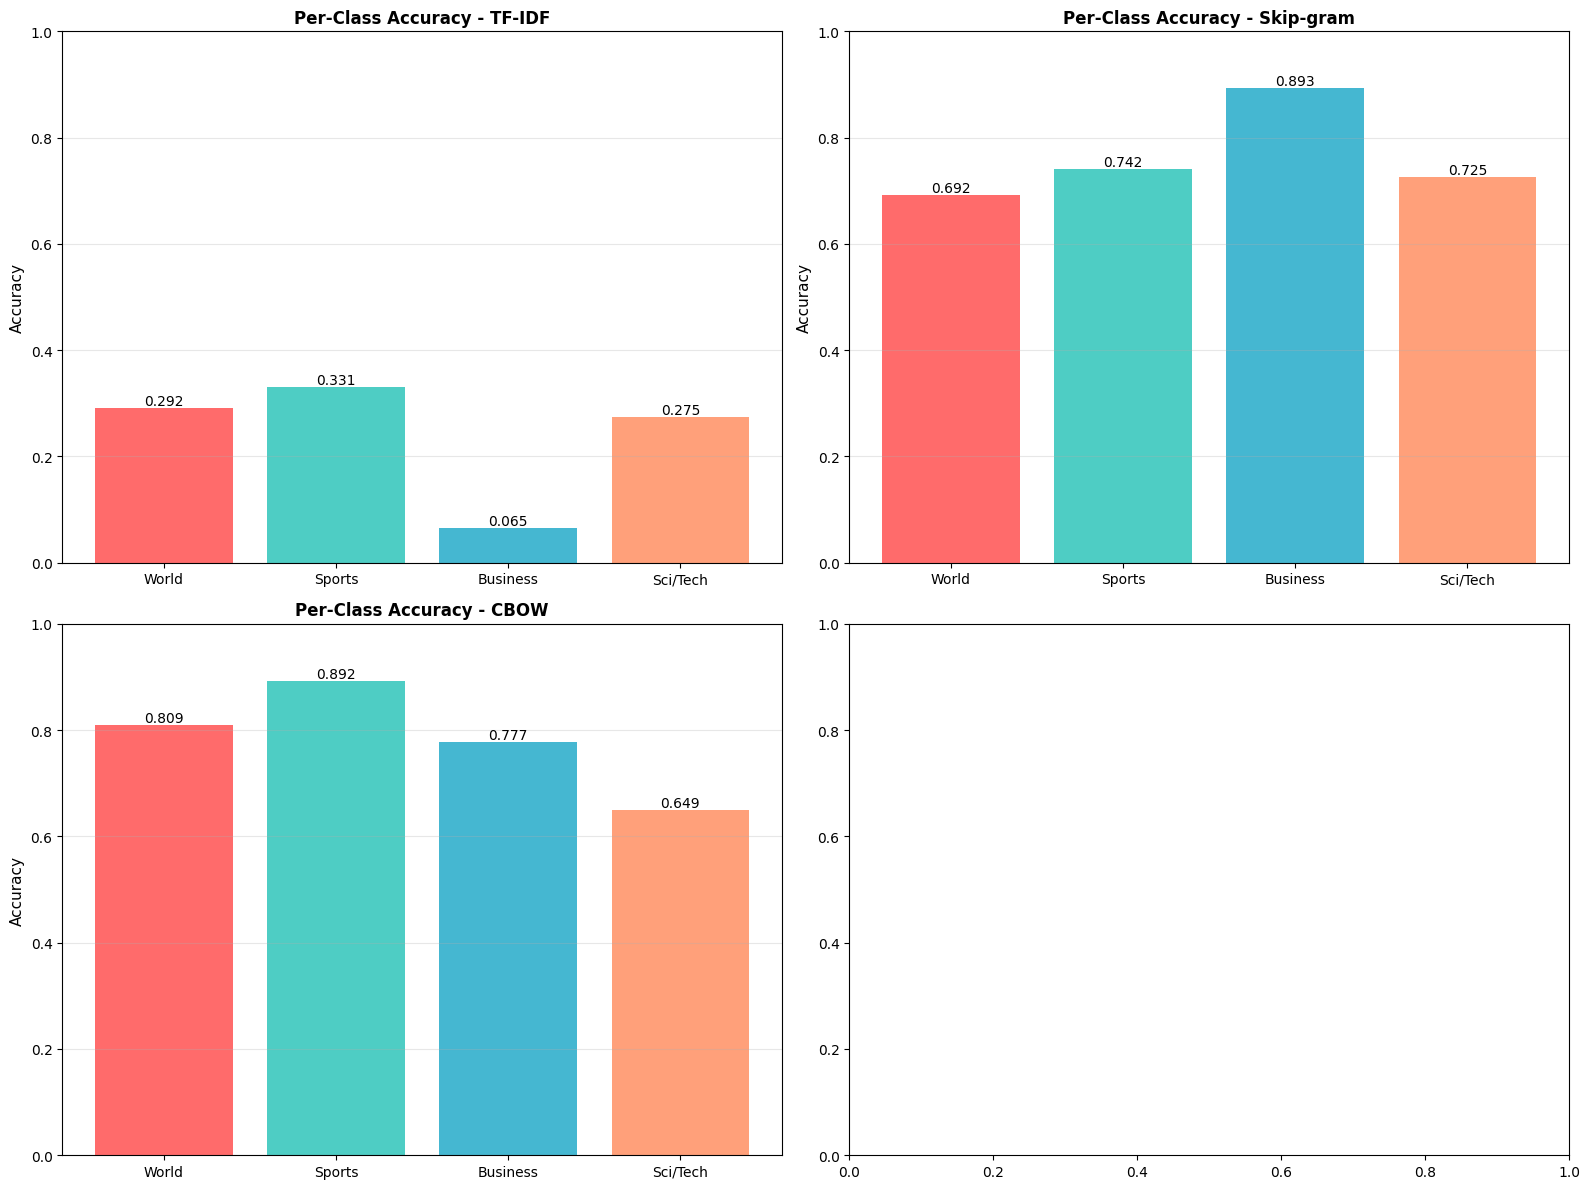

✓ Per-class performance plot saved as 'rnn_per_class_performance.png'


In [73]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (embedding_name, results) in enumerate(results_summary.items()):
    if idx < 4:
        cm = results['confusion_matrix']


        per_class_acc = cm.diagonal() / cm.sum(axis=1)

        bars = axes[idx].bar([class_names[i+1] for i in range(4)], per_class_acc,
                            color=colors_palette)


        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.3f}', ha='center', va='bottom', fontsize=10)

        axes[idx].set_title(f'Per-Class Accuracy - {embedding_name}',
                           fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Accuracy', fontsize=11)
        axes[idx].set_ylim(0, 1.0)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rnn_per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Per-class performance plot saved as 'rnn_per_class_performance.png'")

 Summary and Conclusions

In [74]:
print("\n" + "="*80)
print("EXPERIMENT SUMMARY")
print("="*80)
print(f"\nDataset: AG News (4-class news classification)")
print(f"Model Architecture: Recurrent Neural Network (RNN)")
print(f"Embeddings Tested: {len(results_summary)}")
print(f"\nTotal Training Samples: {len(X_train_text):,}")
print(f"Validation Samples: {len(X_val_text):,}")
print(f"Test Samples: {len(X_test_text):,}")

print("\n" + "-"*80)
print("PERFORMANCE RANKING")
print("-"*80)
for idx, row in results_df.iterrows():
    print(f"{idx+1}. {row['Embedding']:15s} - Accuracy: {row['Accuracy']:.4f}, F1: {row['F1-Score']:.4f}")

print("\n" + "="*80)
print("✓ All experiments completed successfully!")
print("="*80)


EXPERIMENT SUMMARY

Dataset: AG News (4-class news classification)
Model Architecture: Recurrent Neural Network (RNN)
Embeddings Tested: 3

Total Training Samples: 102,000
Validation Samples: 18,000
Test Samples: 7,600

--------------------------------------------------------------------------------
PERFORMANCE RANKING
--------------------------------------------------------------------------------
1. CBOW            - Accuracy: 0.7820, F1: 0.7820
2. Skip-gram       - Accuracy: 0.7628, F1: 0.7661
3. TF-IDF          - Accuracy: 0.2407, F1: 0.2256

✓ All experiments completed successfully!
